In [2]:
# !pip install pykan

In [1]:
import torch
import matplotlib.pyplot as plt
from kan import KAN, create_dataset
from kan.MLP import MLP as kan_MLP
from kan.feynman import get_feynman_dataset

In [2]:
torch.cuda.is_available()

False

In [3]:
class MLP(kan_MLP):

    def __init__(self, width, act='silu', save_act=True, seed=0, device='cpu'):
        super(MLP, self).__init__(width, act, save_act, seed, device)
    
        if act == 'silu':
            self.act_fun = torch.nn.SiLU()
        elif act == 'relu':
            self.act_fun = torch.nn.ReLU()
        elif act == 'tanh':
            self.act_fun = torch.nn.Tanh()

## Experiment Functions

In [ ]:
def run_kan_feynman(dataset: str,
                          shape: list[int],
                          samples: int, # samples for both train and test (separated) sets,
                          test_samples: int = None,
                          start_grid: int = 3,
                          k: int = 3,
                          device='cuda' if torch.cuda.is_available() else 'cpu',
                          seed:int=42,
                          grids=[3, 5, 10, 20, 50, 100, 200],
                          steps_per_grid=200,
                          plot_model=False,
                          prune=False,
                          prune_threshold=1e-2,
                          steps_after_prune=200,
                          lamb=0.00,
                          opt="LBFGS",
                          actual_func = None,
                          **kwargs):
    
    assert device in ['cpu', 'cuda']
    try:
        torch.manual_seed(seed)
    except Exception as e:
        print('Warning: could not set torch.manual_seed')
    

    if test_samples is None:
        test_samples = samples
    
    
    if actual_func is not None:
        f = actual_func
        dataset = create_dataset(f, n_var=2, train_num=samples, test_num=test_samples, seed=seed)
    else:
        try:
            symbol, expr, f, ranges = get_feynman_dataset(dataset)
        except ValueError:
            raise ValueError("Invalid dataset name")
        dataset = create_dataset(f, n_var=2, ranges=ranges, train_num=samples, test_num=samples, seed=seed)
        if not shape[-1] == 1:
            print(f"Warning: Output dimension {shape[-1]} is not 1. Forcing condition.")
            shape[-1] = 1
        if not shape[0] == len(ranges):
            print(f"Warning: Input dimension {shape[0]} does not match number of variables in dataset {len(ranges)}. Forcing condition.")
            shape[0] = len(ranges)


    dataset['train_input'] = dataset['train_input'].to(device)
    dataset['train_label'] = dataset['train_label'].to(device)
    dataset['test_input'] = dataset['test_input'].to(device)
    dataset['test_label'] = dataset['test_label'].to(device)

    # assert shape[0] == len(ranges), "Input dimension does not match number of variables in dataset"
    # print(shape)

    # Create a copy of shape before passing to KAN to avoid mutation
    # KAN's __init__ converts [2,5,1] to [[2,0],[5,0],[1,0]] in-place
    model = KAN(width=shape.copy(), grid=start_grid, k=k, seed=seed).to(device)

    per_grid_results = {}

    for i, g in enumerate(grids):
        if i > 0: #skip first iteration
            model = model.refine(g)
        
        print(f"Training grid: {g}")
        results = model.fit(dataset, opt=opt, steps=steps_per_grid, lamb=lamb) #, verbose=verbose)
        per_grid_results[g] = results

    if prune:
        print("Pruning model...")
        model = model.prune(prune_threshold)
        # Disable grid updates after pruning to avoid numerical instability with smaller network
        results = model.fit(dataset, opt=opt, steps=steps_after_prune, lamb=0.0, update_grid=False) #, verbose=verbose)
        per_grid_results['prunning'] = results
        

    if plot_model:
        model.plot()
        plt.show()

    best_test_rmse = min(per_grid_results.values(), key=lambda x: x['test_loss'][-1])['test_loss'][-1]
    
    return model, per_grid_results, best_test_rmse

In [11]:
def sweep_kan_feynman(dataset:str, width: int=5, depths=[2,3,4,5,6], seeds: list[int] = [42, 171, 3], lambs: list[float] = [0.0], **kwargs):

    all_results = {}
    best_test_rmse = float('inf')
    
    # Get dataset info to determine input dimension
    try:
        symbol, expr, f, ranges = get_feynman_dataset(dataset)
        n_inputs = len(ranges)
    except Exception as e:
        raise ValueError(f"Could not load dataset {dataset}")

    for depth in depths:
        all_results[depth] = {}
        for lamb in lambs:
            all_results[depth][lamb] = {}
            for seed in seeds:
                all_results[depth][lamb][seed] = {}
                # Build shape with correct input dimension and output dimension of 1
                # depth includes input and output layers, so we need depth-2 hidden layers
                if depth == 1:
                    shape = [n_inputs, 1]
                else:
                    shape = [n_inputs] + [width for _ in range(depth - 1)] + [1]


                try:
                    model, per_grid_results, test_rmse = run_kan_feynman(dataset=dataset, shape=shape, lamb=lamb, seed=seed, **kwargs)
                except Exception as e:
                    print(f"Error running run_kan_feynman with depth={depth}, lamb={lamb}, seed={seed}: {e}")
                    model, per_grid_results, test_rmse = None, None, float('inf')
                    
                all_results[depth][lamb][seed] = {
                    'model': model,
                    'per_grid_results': per_grid_results,
                    'test_rmse': test_rmse
                }

                if test_rmse < best_test_rmse:
                    best_test_rmse = test_rmse

    return all_results, best_test_rmse

In [12]:
def feynman_human_kan_experiment(dataset: str, shape: list[int], seeds: int| list[int] = [42, 171, 3], samples: int = 1000, **kwargs):
    """
    Run feynman dataset experiment with human-constructed KAN
    """
    all_results = []
    for seed in seeds:
        results = run_kan_feynman(dataset=dataset,
                                seed=seed,
                                samples=samples,
                                shape=shape,
                                **kwargs)
        all_results.append(results)
    
    best_test_rmse = min([res[2] for res in all_results])

    print('==='*20)
    print(f'Best Test RMSE for human-constructed KAN on dataset {dataset}: {best_test_rmse:.4e}')

    return best_test_rmse, all_results
    

def feynman_not_pruned_kan_experiment(dataset: str, seeds: int | list[int], samples=1000, **kwargs):

    results = sweep_kan_feynman(dataset=dataset,
                                seeds=seeds,
                                samples=samples,
                                **kwargs)

    # print('==='*20)
    # print(f'Best Test RMSE for not pruned KAN on dataset {dataset}: {results[1]:.4e}')
    best_test_rmse = results[1]

    return best_test_rmse, results


def feynman_pruned_kan_experiment(dataset: str, seeds: int|list[int] = [42, 171, 3], samples: int = 1000, steps_after_prune: int = 100,  lambs=[1e-2, 1e-3], **kwargs):
    """
    Run feynman dataset experiment with pruned KAN
    """
    results, best_test_rmse = sweep_kan_feynman(dataset=dataset,
                                seeds=seeds,
                                samples=samples,
                                prune=True,
                                prune_threshold=0.01,
                                steps_after_prune=steps_after_prune,
                                lambs=lambs,
                                **kwargs)
    

    # get smallest shape with loss < 1e-2
    # get shape of best loss

    smallest_shape = None
    smallest_params = float('inf')
    shape_best_loss = None
    smallest_loss = float('inf')

    for depth, v in results.items():
        for lamb, vv in v.items():
            for seed, res in vv.items():
                test_rmse = res['test_rmse']
                model = res['model']
                
                # Skip if model is None (failed training)
                if model is None:
                    continue
                
                shape = [p[0] if isinstance(p, list) else p for p in model.width]
                num_params = sum(p.numel() for p in model.parameters())


                if test_rmse < 1e-2:
                    if smallest_shape is None or sum(shape) < sum(smallest_shape):
                        if num_params > smallest_params and smallest_shape is not None:
                            print(f"Warning: Found smaller shape {shape} with more parameters {num_params} > {smallest_params}. Still taking smallest shape though.")
                        smallest_shape = shape
                        smallest_params = num_params

                if test_rmse < smallest_loss:
                    smallest_loss = test_rmse
                    shape_best_loss = shape


    
    # If no model achieved RMSE < 1e-2, print warning
    if smallest_shape is None:

        print(f"⚠️ WARNING: No model achieved RMSE < 1e-2 for dataset {dataset}")


    return smallest_shape, shape_best_loss, best_test_rmse, results

In [13]:
def feynman_mlp_experiment(dataset: str, seeds: int|list[int] = [42, 171, 3], samples: int = 1000, device='cuda' if torch.cuda.is_available() else 'cpu',
                           activations=['silu', 'relu', 'tanh'], depths = [2,3,4,5,6], steps=1400, lr=1, **kwargs):
    """
    Run feynman dataset experiment with MLP
    """

    assert device in ['cpu', 'cuda']

    all_results = {}
    best_test_rmse = float('inf')

    try:
        symbol, expr, f, ranges = get_feynman_dataset(dataset)
    except ValueError:
        raise ValueError("Invalid dataset name")
    
    for seed in seeds:
        try:
            torch.manual_seed(seed)
        except Exception as e:
            print(f"Warning: could not set seed due to error: {e}")

        dataset = create_dataset(f, n_var=len(ranges), ranges=ranges, train_num=samples, test_num=samples, seed=seed)
        dataset['train_input'] = dataset['train_input'].to(device)
        dataset['train_label'] = dataset['train_label'].to(device)
        dataset['test_input'] = dataset['test_input'].to(device)
        dataset['test_label'] = dataset['test_label'].to(device)

        all_results[seed] = {}
        
        for depth in depths:
            shape = [len(ranges)] + [5 for _ in range(depth-1)] + [1]

            all_results[seed][depth] = {}

            for act in activations:
                model = MLP(width=shape, act=act, seed=seed, device=device)

                results = model.fit(dataset=dataset, steps=steps, opt="LBFGS", lr=lr)
                all_results[seed][depth][act] = results

                test_rmse = min(results['test_loss'])

                if test_rmse < best_test_rmse:
                    best_test_rmse = test_rmse
                
    return all_results, best_test_rmse

In [14]:
def full_feynman_experiment(dataset: str, shape_human: list[int], seeds: list[int] = [42, 171, 3], samples: int = 1000, skip = [], **kwargs):
    """
    Run full feynman dataset experiment with human-constructed KAN, not pruned KAN, pruned KAN, and MLP
    """

    pruned_smallest_shape, pruned_shape_best_loss, pruned_best_rmse = None, None, None
    h_best_test_rmse, not_pruned_best_rmse, mlp_best_rmse = None, None, None

    if 'human' not in skip:
        print('Running Human-constructed KAN Experiment...')
        h_best_test_rmse, h_results = feynman_human_kan_experiment(dataset=dataset, shape=shape_human, seeds=seeds, samples=samples, **kwargs)
        print(f'Best Test RMSE for human-constructed KAN on dataset {dataset}: {h_best_test_rmse:.4e}')

    if 'unpruned' not in skip:
        print('--------------------------------') 
        print('Running Not Pruned KAN Experiment...')
        not_pruned_best_rmse, not_pruned_results = feynman_not_pruned_kan_experiment(dataset=dataset, seeds=seeds, samples=samples, **kwargs)
        print(f'Best Test RMSE for not pruned KAN on dataset {dataset}: {not_pruned_best_rmse:.4e}')

    if 'pruned' not in skip:
        print('--------------------------------') 
        print('Running Pruned KAN Experiment...')
        pruned_smallest_shape, pruned_shape_best_loss, pruned_best_rmse, pruned_results = feynman_pruned_kan_experiment(dataset=dataset, seeds=seeds, samples=samples, **kwargs)
        print(f'Pruned KAN Smallest Shape: {pruned_smallest_shape}, ')
        print(f'Pruned KAN lowest loss Shape: {pruned_shape_best_loss}, ')
        print(f'Pruned KAN lowest loss: {pruned_best_rmse:.4e}')

    if 'mlp' not in skip:
        print('--------------------------------') 
        print('Running MLP Experiment...')
        mlp_results, mlp_best_rmse = feynman_mlp_experiment(dataset=dataset, seeds=seeds, samples=samples, **kwargs)
        print(f'MLP lowest loss: {mlp_best_rmse:.4e}')

    print('--------------------------------') 
    print('==='*40)
    print('==='*40)
    print(f'Final Results for dataset {dataset}:')

    if 'pruned' not in skip:
        print(f'Pruned KAN Smallest Shape: {pruned_smallest_shape}, ')
        print(f'Pruned KAN lowest loss Shape: {pruned_shape_best_loss}, ')
        print(f'Pruned KAN lowest loss: {pruned_best_rmse:.4e}')
    if 'human' not in skip:
        print(f'Human-constructed KAN loss: {h_best_test_rmse:.4e}')
    if 'unpruned' not in skip:
        print(f'UnPruned KAN lowest loss: {not_pruned_best_rmse:.4e}')
    if 'mlp' not in skip:
        print(f'MLP lowest loss: {mlp_best_rmse:.4e}')
    print('==='*40)
    print('==='*40)

    # save results
    full_results = {
        'human': {
            'best_rmse': h_best_test_rmse,
            'results': h_results
        } if 'human' not in skip else None,
        'not_pruned': {
            'best_rmse': not_pruned_best_rmse,
            'results': not_pruned_results
        } if 'unpruned' not in skip else None,
        'pruned': {
            'smallest_shape': pruned_smallest_shape,
            'shape_best_loss': pruned_shape_best_loss,
            'best_rmse': pruned_best_rmse,
            'results': pruned_results
        } if 'pruned' not in skip else None,
        'mlp': {
            'best_rmse': mlp_best_rmse,
            'results': mlp_results
        } if 'mlp' not in skip else None    
    }

    return full_results

## Experiments

--------------------------------
Running Pruned KAN Experiment...
checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


description:   0%|                                                          | 0/200 [00:00<?, ?it/s]

| train_loss: 1.11e-01 | test_loss: 1.10e-01 | reg: 1.36e-01 | : 100%|█| 200/200 [00:52<00:00,  3.79


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 1.23e-01 | test_loss: 1.23e-01 | reg: 1.36e-01 | : 100%|█| 200/200 [00:16<00:00, 11.85


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 1.23e-01 | test_loss: 1.23e-01 | reg: 1.45e-01 | : 100%|█| 200/200 [00:11<00:00, 17.41


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 1.23e-01 | test_loss: 1.23e-01 | reg: 1.84e-01 | : 100%|█| 200/200 [00:13<00:00, 14.82


saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: 1.11e-01 | test_loss: 1.10e-01 | reg: 1.78e-02 | : 100%|█| 200/200 [01:17<00:00,  2.57


saving model version 0.9
saving model version 0.10
Training grid: 100


| train_loss: 2.25e-01 | test_loss: 2.25e-01 | reg: 3.11e-02 | : 100%|█| 200/200 [01:39<00:00,  2.01


saving model version 0.11
saving model version 0.12
Training grid: 200


| train_loss: 2.28e-01 | test_loss: 2.28e-01 | reg: 2.34e-02 | : 100%|█| 200/200 [02:16<00:00,  1.46


saving model version 0.13


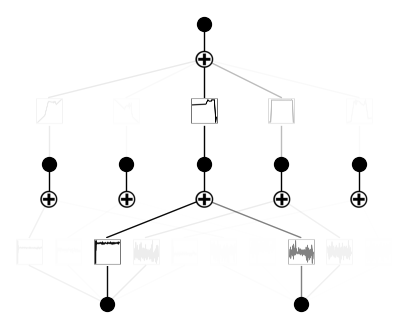

Pruning model...
saving model version 0.14


| train_loss: 4.17e-02 | test_loss: 5.89e-02 | reg: 3.27e+00 | : 100%|█| 100/100 [00:46<00:00,  2.15


saving model version 0.15


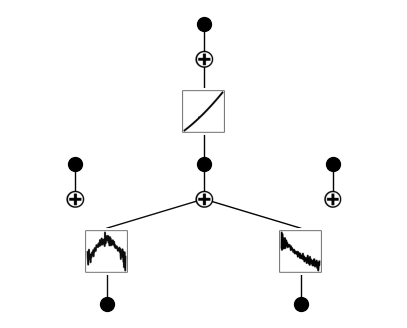

checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


| train_loss: 2.00e-02 | test_loss: 2.11e-02 | reg: 5.35e+00 | : 100%|█| 200/200 [00:35<00:00,  5.69


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 2.64e-02 | test_loss: 2.77e-02 | reg: 5.10e+00 | : 100%|█| 200/200 [00:40<00:00,  4.89


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 2.34e-02 | test_loss: 2.41e-02 | reg: 4.93e+00 | : 100%|█| 200/200 [00:59<00:00,  3.39


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 1.84e-02 | test_loss: 2.22e-02 | reg: 4.91e+00 | : 100%|█| 200/200 [00:42<00:00,  4.71


saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: 1.66e-02 | test_loss: 2.07e-02 | reg: 4.89e+00 | : 100%|█| 200/200 [01:04<00:00,  3.10


saving model version 0.9
saving model version 0.10
Training grid: 100


| train_loss: 1.55e-02 | test_loss: 2.07e-02 | reg: 4.88e+00 | : 100%|█| 200/200 [01:07<00:00,  2.97


saving model version 0.11
saving model version 0.12
Training grid: 200


| train_loss: 1.16e-02 | test_loss: 2.33e-02 | reg: 4.79e+00 | : 100%|█| 200/200 [01:54<00:00,  1.74


saving model version 0.13


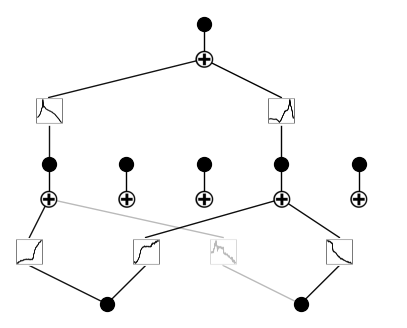

Pruning model...
saving model version 0.14


| train_loss: 5.58e-04 | test_loss: 2.63e-02 | reg: 6.12e+00 | : 100%|█| 100/100 [00:28<00:00,  3.46


saving model version 0.15


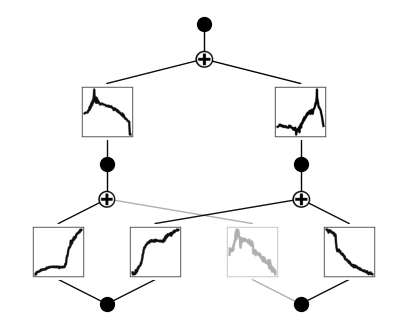

checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


| train_loss: 1.11e-01 | test_loss: 1.10e-01 | reg: 6.27e-01 | : 100%|█| 200/200 [01:12<00:00,  2.76


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 1.13e-01 | test_loss: 1.12e-01 | reg: 1.15e+00 | : 100%|█| 200/200 [01:34<00:00,  2.12


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 2.10e-01 | test_loss: 2.10e-01 | reg: 1.39e-01 | : 100%|█| 200/200 [01:13<00:00,  2.71


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 2.31e-01 | test_loss: 2.32e-01 | reg: 8.44e-02 | : 100%|█| 200/200 [01:46<00:00,  1.88


saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: 2.97e-01 | test_loss: 2.98e-01 | reg: 5.45e-02 | : 100%|█| 200/200 [01:04<00:00,  3.09


saving model version 0.9
saving model version 0.10
Training grid: 100


| train_loss: 2.97e-01 | test_loss: 2.98e-01 | reg: 9.17e-02 | : 100%|█| 200/200 [00:57<00:00,  3.46


saving model version 0.11
saving model version 0.12
Training grid: 200


| train_loss: 2.96e-01 | test_loss: 2.96e-01 | reg: 1.82e-01 | : 100%|█| 200/200 [33:23<00:00, 10.02


saving model version 0.13


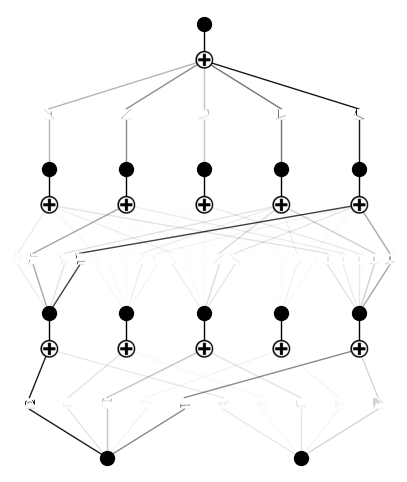

Pruning model...
saving model version 0.14


| train_loss: 4.99e-02 | test_loss: 5.92e-02 | reg: 1.16e+01 | : 100%|█| 100/100 [1:05:11<00:00, 39.


saving model version 0.15


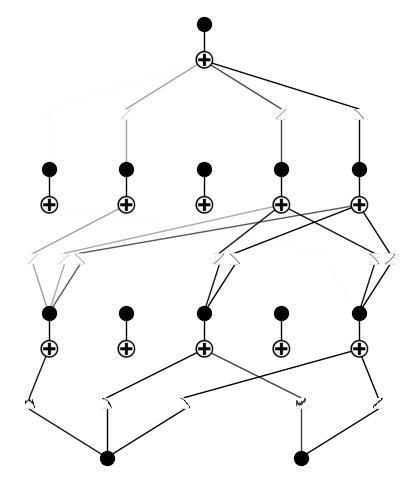

checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


| train_loss: 2.28e-02 | test_loss: 2.62e-02 | reg: 6.55e+00 | : 100%|█| 200/200 [01:40<00:00,  2.00


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 3.19e-02 | test_loss: 3.33e-02 | reg: 7.79e+00 | : 100%|█| 200/200 [00:47<00:00,  4.22


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 9.22e-02 | test_loss: 9.26e-02 | reg: 6.89e+00 | : 100%|█| 200/200 [01:04<00:00,  3.10


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 1.02e-01 | test_loss: 1.02e-01 | reg: 6.92e+00 | : 100%|█| 200/200 [00:34<00:00,  5.83


saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: 1.01e-01 | test_loss: 1.02e-01 | reg: 6.92e+00 | : 100%|█| 200/200 [00:35<00:00,  5.59


saving model version 0.9
saving model version 0.10
Training grid: 100


| train_loss: 1.01e-01 | test_loss: 1.47e-01 | reg: 6.90e+00 | : 100%|█| 200/200 [00:38<00:00,  5.25


saving model version 0.11
saving model version 0.12
Training grid: 200


| train_loss: nan | test_loss: nan | reg: nan | :   2%|▎          | 5/200 [03:10<2:03:45, 38.08s/it]



Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.
lstsq failed
Error running run_kan_feynman with depth=3, lamb=0.001, seed=1: cannot access local variable 'coef' where it is not associated with a value
checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


| train_loss: 1.11e-01 | test_loss: 1.10e-01 | reg: 7.48e-01 | : 100%|█| 200/200 [00:35<00:00,  5.57


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 1.21e-01 | test_loss: 1.22e-01 | reg: 1.81e+00 | : 100%|█| 200/200 [00:55<00:00,  3.63


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 3.27e-01 | test_loss: 3.28e-01 | reg: 6.57e-01 | : 100%|█| 200/200 [00:56<00:00,  3.52


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 3.28e-01 | test_loss: 3.28e-01 | reg: 6.59e-01 | : 100%|█| 200/200 [00:49<00:00,  4.07


saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: 3.27e-01 | test_loss: 3.28e-01 | reg: 6.54e-01 | : 100%|█| 200/200 [00:56<00:00,  3.56


saving model version 0.9
saving model version 0.10
Training grid: 100


| train_loss: 3.29e-01 | test_loss: 3.30e-01 | reg: 9.07e-01 | : 100%|█| 200/200 [36:02<00:00, 10.81


saving model version 0.11
saving model version 0.12
Training grid: 200


| train_loss: 3.28e-01 | test_loss: 3.28e-01 | reg: 2.85e+00 | : 100%|█| 200/200 [56:12<00:00, 16.86


saving model version 0.13


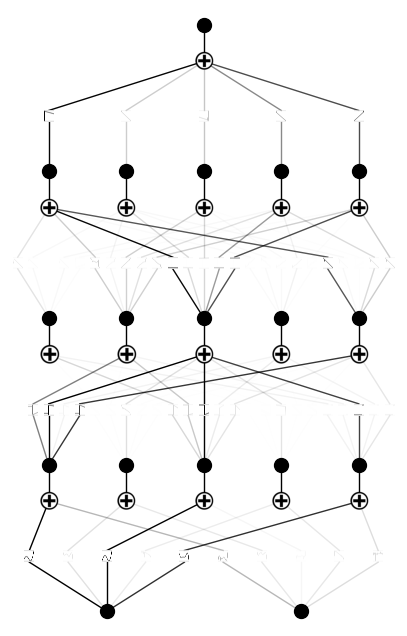

Pruning model...
saving model version 0.14


| train_loss: 3.06e-01 | test_loss: 3.07e-01 | reg: 0.00e+00 | :  12%| | 12/100 [14:01<1:42:48, 70.0


KeyboardInterrupt: 

In [24]:
results_I_6_20 = full_feynman_experiment(dataset='I.6.20', shape_human=[6, 4, 2, 1, 1], seeds=[1], skip=['unpruned','human','mlp'], depths=[2,3,4], plot_model=True, plot_before_prune=True)

--------------------------------
Running Pruned KAN Experiment...
checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


| train_loss: 1.38e-01 | test_loss: 1.33e-01 | reg: 5.36e-01 | : 100%|█| 200/200 [00:22<00:00,  8.87


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 1.38e-01 | test_loss: 1.33e-01 | reg: 2.99e-01 | : 100%|█| 200/200 [00:38<00:00,  5.17


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 1.38e-01 | test_loss: 1.33e-01 | reg: 1.21e-01 | : 100%|█| 200/200 [00:44<00:00,  4.51


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 1.38e-01 | test_loss: 1.33e-01 | reg: 1.17e-01 | : 100%|█| 200/200 [00:22<00:00,  8.97


saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: 1.38e-01 | test_loss: 1.33e-01 | reg: 2.53e-02 | : 100%|█| 200/200 [00:53<00:00,  3.73


saving model version 0.9
saving model version 0.10
Training grid: 100


| train_loss: 1.47e-01 | test_loss: 1.40e-01 | reg: 9.21e-02 | : 100%|█| 200/200 [01:21<00:00,  2.45


saving model version 0.11
saving model version 0.12
Training grid: 200


| train_loss: 1.74e-01 | test_loss: 1.69e-01 | reg: 8.65e-02 | : 100%|█| 200/200 [02:28<00:00,  1.35


saving model version 0.13


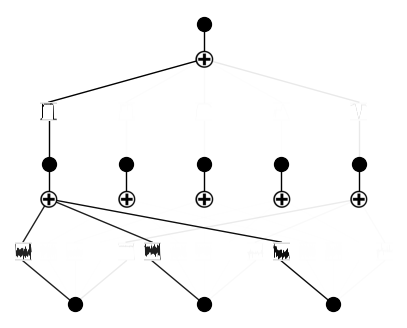

Pruning model...
saving model version 0.14


| train_loss: 1.19e-01 | test_loss: 1.73e-01 | reg: 2.20e+00 | : 100%|█| 100/100 [00:31<00:00,  3.16


saving model version 0.15


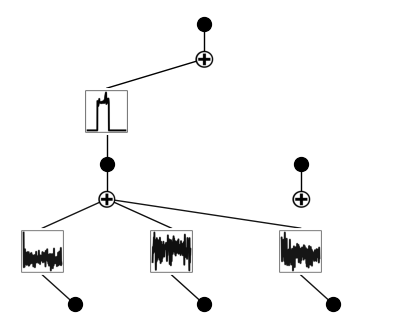

checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


| train_loss: 3.00e-02 | test_loss: 3.19e-02 | reg: 5.83e+00 | : 100%|█| 200/200 [00:57<00:00,  3.47


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 2.49e-02 | test_loss: 2.66e-02 | reg: 5.51e+00 | : 100%|█| 200/200 [00:55<00:00,  3.63


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 2.41e-02 | test_loss: 2.77e-02 | reg: 5.36e+00 | : 100%|█| 200/200 [00:36<00:00,  5.50


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 2.40e-02 | test_loss: 2.81e-02 | reg: 5.33e+00 | : 100%|█| 200/200 [00:42<00:00,  4.65


saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: 2.34e-02 | test_loss: 2.87e-02 | reg: 5.33e+00 | : 100%|█| 200/200 [00:39<00:00,  5.04


saving model version 0.9
saving model version 0.10
Training grid: 100


| train_loss: 2.04e-02 | test_loss: 3.07e-02 | reg: 5.31e+00 | : 100%|█| 200/200 [01:13<00:00,  2.73


saving model version 0.11
saving model version 0.12
Training grid: 200


| train_loss: 1.42e-02 | test_loss: 3.40e-02 | reg: 5.28e+00 | : 100%|█| 200/200 [02:09<00:00,  1.55


saving model version 0.13


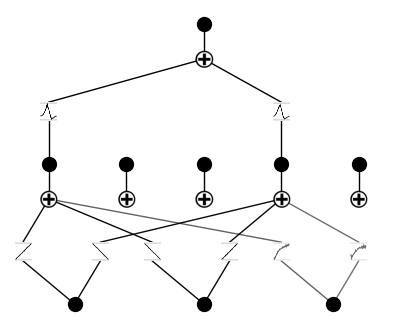

Pruning model...
saving model version 0.14


| train_loss: 7.97e-04 | test_loss: 4.59e-02 | reg: 6.64e+00 | : 100%|█| 100/100 [00:33<00:00,  3.01


saving model version 0.15


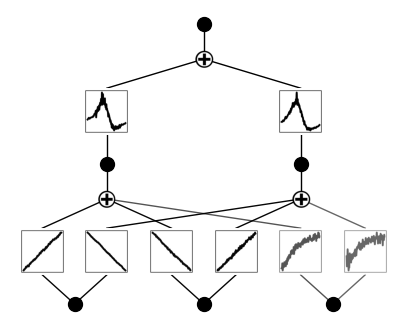

checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


| train_loss: 1.38e-01 | test_loss: 1.33e-01 | reg: 6.25e-01 | : 100%|█| 200/200 [00:57<00:00,  3.46


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 1.38e-01 | test_loss: 1.33e-01 | reg: 4.87e-01 | : 100%|█| 200/200 [01:32<00:00,  2.17


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 1.49e-01 | test_loss: 1.41e-01 | reg: 4.89e-01 | : 100%|█| 200/200 [00:42<00:00,  4.67


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 1.49e-01 | test_loss: 1.42e-01 | reg: 1.10e+00 | : 100%|█| 200/200 [00:59<00:00,  3.36


saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: 1.55e-01 | test_loss: 1.51e-01 | reg: 1.22e+00 | : 100%|█| 200/200 [02:00<00:00,  1.66


saving model version 0.9
saving model version 0.10
Training grid: 100


| train_loss: 1.58e-01 | test_loss: 1.56e-01 | reg: 1.72e+00 | : 100%|█| 200/200 [01:50<00:00,  1.82


saving model version 0.11
saving model version 0.12
Training grid: 200


| train_loss: 2.02e-01 | test_loss: 1.93e-01 | reg: 7.26e-01 | :  22%|▏| 44/200 [18:55<1:07:07, 25.8


KeyboardInterrupt: 

In [25]:
results_I_6_20b = full_feynman_experiment(dataset='I.6.20b', shape_human=[3,2,2,1,1], seeds=[3], skip=['unpruned','human','mlp'], depths=[2,3,4,5], plot_model=True, plot_before_prune=True)

--------------------------------
Running Pruned KAN Experiment...
checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


| train_loss: 1.43e-01 | test_loss: 1.33e-01 | reg: 6.44e-01 | :   5%| | 10/200 [00:02<00:46,  4.11i

| train_loss: 1.43e-01 | test_loss: 1.33e-01 | reg: 6.43e-01 | : 100%|█| 200/200 [00:33<00:00,  5.97


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 1.43e-01 | test_loss: 1.33e-01 | reg: 2.02e-01 | : 100%|█| 200/200 [00:38<00:00,  5.17


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 1.43e-01 | test_loss: 1.32e-01 | reg: 8.62e-02 | : 100%|█| 200/200 [00:36<00:00,  5.54


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 1.43e-01 | test_loss: 1.32e-01 | reg: 2.93e-02 | : 100%|█| 200/200 [00:51<00:00,  3.89


saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: 1.74e-01 | test_loss: 1.60e-01 | reg: 3.63e-02 | : 100%|█| 200/200 [00:46<00:00,  4.28


saving model version 0.9
saving model version 0.10
Training grid: 100


| train_loss: 2.35e-01 | test_loss: 2.22e-01 | reg: 2.33e-02 | : 100%|█| 200/200 [01:36<00:00,  2.08


saving model version 0.11
saving model version 0.12
Training grid: 200


| train_loss: 2.38e-01 | test_loss: 2.25e-01 | reg: 1.24e-02 | : 100%|█| 200/200 [01:22<00:00,  2.41


saving model version 0.13


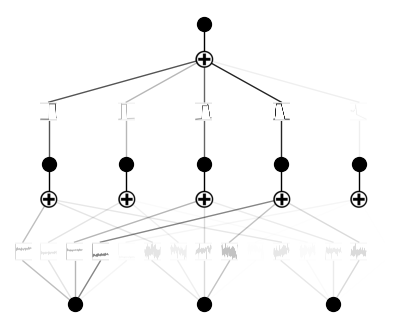

Pruning model...
saving model version 0.14


| train_loss: 1.96e-01 | test_loss: 2.36e-01 | reg: 5.12e+00 | : 100%|█| 100/100 [00:58<00:00,  1.72


saving model version 0.15


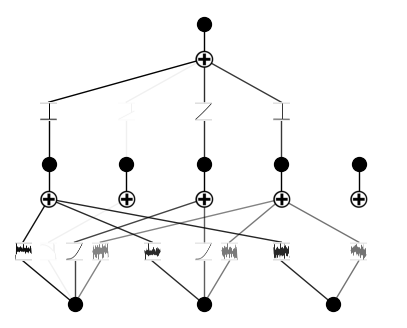

checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


| train_loss: 2.97e-02 | test_loss: 2.81e-02 | reg: 6.26e+00 | : 100%|█| 200/200 [00:39<00:00,  5.02


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 2.42e-02 | test_loss: 2.27e-02 | reg: 5.87e+00 | : 100%|█| 200/200 [00:56<00:00,  3.57


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 2.47e-02 | test_loss: 2.37e-02 | reg: 5.64e+00 | : 100%|█| 200/200 [01:12<00:00,  2.77


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 2.50e-02 | test_loss: 2.70e-02 | reg: 5.62e+00 | : 100%|█| 200/200 [01:05<00:00,  3.05


saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: 2.00e-02 | test_loss: 5.12e-02 | reg: 5.27e+00 | : 100%|█| 200/200 [01:08<00:00,  2.93


saving model version 0.9
saving model version 0.10
Training grid: 100


| train_loss: 1.62e-02 | test_loss: 5.36e-02 | reg: 5.23e+00 | : 100%|█| 200/200 [01:31<00:00,  2.19


saving model version 0.11
saving model version 0.12
Training grid: 200


| train_loss: 1.25e-02 | test_loss: 5.69e-02 | reg: 5.21e+00 | : 100%|█| 200/200 [02:02<00:00,  1.63


saving model version 0.13


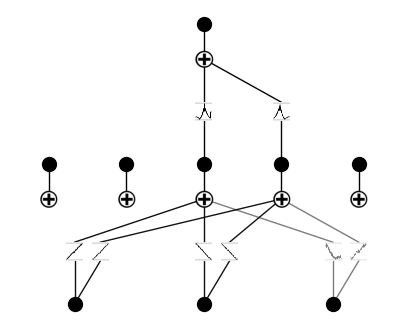

Pruning model...
saving model version 0.14


| train_loss: 4.82e-04 | test_loss: 6.32e-02 | reg: 6.69e+00 | : 100%|█| 100/100 [00:32<00:00,  3.03


saving model version 0.15


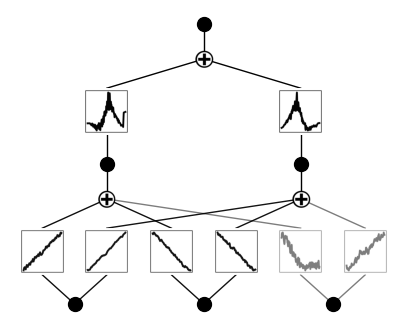

⚠️ WARNING: No model achieved RMSE < 1e-2 for dataset I.6.20b
Pruned KAN Smallest Shape: None, 
Pruned KAN lowest loss Shape: [3, 2, 1], 
Pruned KAN lowest loss: 2.2746e-02
--------------------------------
Final Results for dataset I.6.20b:
Pruned KAN Smallest Shape: None, 
Pruned KAN lowest loss Shape: [3, 2, 1], 
Pruned KAN lowest loss: 2.2746e-02


In [26]:
results_I_6_20b = full_feynman_experiment(dataset='I.6.20b', shape_human=[3,2,2,1,1], seeds=[1], skip=['unpruned','human','mlp'], depths=[2], plot_model=True, plot_before_prune=True)

In [ ]:
results_I_6_20b = full_feynman_experiment(dataset='I.6.20b', shape_human=[3,2,2,1,1], seeds=[1], skip=['unpruned','human','mlp'], depths=[3], lambs=[1e-3, 1e-2], plot_model=True, plot_before_prune=True)

--------------------------------
Running Pruned KAN Experiment...


checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


| train_loss: 4.34e-02 | test_loss: 4.34e-02 | reg: 3.92e+00 | : 100%|█| 200/200 [01:26<00:00,  2.31


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 8.80e-03 | test_loss: 9.99e-03 | reg: 3.24e+00 | : 100%|█| 200/200 [01:27<00:00,  2.28


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 3.32e-02 | test_loss: 3.97e-02 | reg: 3.78e+00 | : 100%|█| 200/200 [01:00<00:00,  3.29


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 3.18e-02 | test_loss: 3.93e-02 | reg: 4.16e+00 | : 100%|█| 200/200 [00:49<00:00,  4.06


saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: 3.43e-02 | test_loss: 4.19e-02 | reg: 3.74e+00 | : 100%|█| 200/200 [01:02<00:00,  3.20


saving model version 0.9
saving model version 0.10
Training grid: 100


| train_loss: 1.52e-01 | test_loss: 1.39e-01 | reg: 2.75e+00 | :   6%| | 13/200 [00:13<03:15,  1.05s


KeyboardInterrupt: 

--------------------------------
Running Pruned KAN Experiment...
checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


| train_loss: 5.67e-03 | test_loss: 6.79e-03 | reg: 7.28e+00 | : 100%|█| 200/200 [01:20<00:00,  2.50


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 5.83e-03 | test_loss: 7.11e-03 | reg: 4.76e+00 | : 100%|█| 200/200 [01:29<00:00,  2.24


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 5.90e-03 | test_loss: 3.04e-02 | reg: 7.72e+00 | : 100%|█| 200/200 [01:38<00:00,  2.03


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 7.54e-03 | test_loss: 8.43e-02 | reg: 8.60e+00 | : 100%|█| 200/200 [01:41<00:00,  1.97


saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: 2.32e-03 | test_loss: 9.04e-02 | reg: 7.97e+00 | : 100%|█| 200/200 [01:53<00:00,  1.77


saving model version 0.9
saving model version 0.10
Training grid: 100


| train_loss: 2.77e-03 | test_loss: 1.04e-01 | reg: 7.11e+00 | : 100%|█| 200/200 [02:43<00:00,  1.22


saving model version 0.11
saving model version 0.12
Training grid: 200


| train_loss: 6.76e-03 | test_loss: 1.02e-01 | reg: 7.20e+00 | : 100%|█| 200/200 [1:50:11<00:00, 33.


saving model version 0.13


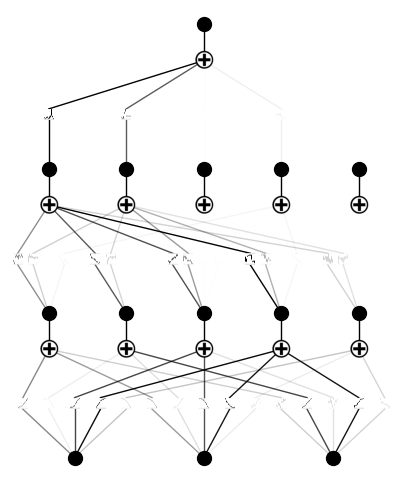

Pruning model...
saving model version 0.14


| train_loss: 9.20e-02 | test_loss: 1.68e-01 | reg: 0.00e+00 | :  82%|▊| 82/100 [47:00<11:10, 37.28s

In [ ]:
results_I_6_20b = full_feynman_experiment(dataset='I.6.20b', shape_human=[3,2,2,1,1], seeds=[1], skip=['unpruned','human','mlp'], depths=[3], lambs=[1e-4, 1e-2], plot_model=True, plot_before_prune=True)

In [15]:
results_I_16_6 = full_feynman_experiment(dataset='I.16.6', shape_human=[6, 4, 2, 1, 1], seeds=[171], skip=['unpruned','human','mlp'], depths=[2], plot_model=True, plot_before_prune=True)

--------------------------------
Running Pruned KAN Experiment...
checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


description:   0%|                                                          | 0/200 [00:00<?, ?it/s]

| train_loss: 2.37e-01 | test_loss: 2.30e-01 | reg: 1.26e-01 | : 100%|█| 200/200 [00:46<00:00,  4.28


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 2.37e-01 | test_loss: 2.30e-01 | reg: 6.45e-02 | : 100%|█| 200/200 [00:31<00:00,  6.33


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 2.37e-01 | test_loss: 2.30e-01 | reg: 2.22e-02 | : 100%|█| 200/200 [00:33<00:00,  5.93


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 2.37e-01 | test_loss: 2.30e-01 | reg: 1.01e-02 | : 100%|█| 200/200 [00:52<00:00,  3.78


saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: nan | test_loss: nan | reg: nan | :   2%|▎            | 5/200 [00:02<01:28,  2.21it/s]



Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGE

| train_loss: 2.56e-02 | test_loss: 2.39e-02 | reg: 6.18e+00 | : 100%|█| 200/200 [00:38<00:00,  5.16


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 2.50e-02 | test_loss: 2.29e-02 | reg: 6.14e+00 | : 100%|█| 200/200 [00:33<00:00,  6.03


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 2.41e-02 | test_loss: 2.33e-02 | reg: 6.12e+00 | : 100%|█| 200/200 [00:51<00:00,  3.91


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: nan | test_loss: nan | reg: nan | :   2%|▎            | 5/200 [00:02<01:19,  2.44it/s]


Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGE

In [19]:
results_I_16_6 = full_feynman_experiment(dataset='I.27.6', shape_human=[6, 4, 2, 1, 1], seeds=[0], skip=['unpruned','human','mlp'], depths=[2], plot_model=True, plot_before_prune=True)

--------------------------------
Running Pruned KAN Experiment...
checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


description:   0%|                                                          | 0/200 [00:00<?, ?it/s]

| train_loss: 7.18e-02 | test_loss: 6.85e-02 | reg: 3.16e+00 | : 100%|█| 200/200 [00:54<00:00,  3.69


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 6.38e-02 | test_loss: 6.29e-02 | reg: 3.16e+00 | : 100%|█| 200/200 [00:41<00:00,  4.81


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 6.37e-02 | test_loss: 6.29e-02 | reg: 3.16e+00 | : 100%|█| 200/200 [00:22<00:00,  8.94


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 6.37e-02 | test_loss: 6.29e-02 | reg: 3.16e+00 | : 100%|█| 200/200 [00:23<00:00,  8.60


saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: nan | test_loss: nan | reg: nan | :   8%|▉           | 15/200 [00:04<00:56,  3.27it/s]



Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGE

| train_loss: 1.92e-02 | test_loss: 1.96e-02 | reg: 3.26e+00 | : 100%|█| 200/200 [00:35<00:00,  5.57


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 1.88e-02 | test_loss: 1.93e-02 | reg: 3.17e+00 | : 100%|█| 200/200 [00:36<00:00,  5.41


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 1.87e-02 | test_loss: 1.97e-02 | reg: 3.09e+00 | : 100%|█| 200/200 [00:38<00:00,  5.13


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 1.86e-02 | test_loss: 1.97e-02 | reg: 3.09e+00 | : 100%|█| 200/200 [00:28<00:00,  7.02


saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: 1.71e-02 | test_loss: 2.04e-02 | reg: 3.06e+00 | : 100%|█| 200/200 [00:39<00:00,  5.10


saving model version 0.9
saving model version 0.10
Training grid: 100


| train_loss: nan | test_loss: nan | reg: nan | :   2%|▎            | 5/200 [00:02<01:39,  1.96it/s]


Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGELSY.

Intel oneMKL ERROR: Parameter 6 was incorrect on entry to SGE

--------------------------------
Running Pruned KAN Experiment...
checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


description:   0%|                                                          | 0/200 [00:00<?, ?it/s]

| train_loss: 2.27e-01 | test_loss: 2.30e-01 | reg: 3.20e-01 | : 100%|█| 200/200 [00:38<00:00,  5.25


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 2.29e-01 | test_loss: 2.32e-01 | reg: 3.53e-01 | : 100%|█| 200/200 [00:30<00:00,  6.59


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 2.29e-01 | test_loss: 2.32e-01 | reg: 3.47e-01 | : 100%|█| 200/200 [00:32<00:00,  6.15


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 2.35e-01 | test_loss: 2.38e-01 | reg: 9.16e-01 | : 100%|█| 200/200 [00:43<00:00,  4.55


saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: 2.36e-01 | test_loss: 2.38e-01 | reg: 4.47e-01 | : 100%|█| 200/200 [00:53<00:00,  3.71


saving model version 0.9
saving model version 0.10
Training grid: 100


| train_loss: 2.37e-01 | test_loss: 2.39e-01 | reg: 3.39e-01 | : 100%|█| 200/200 [01:45<00:00,  1.90


saving model version 0.11
saving model version 0.12
Training grid: 200


| train_loss: 2.29e-01 | test_loss: 2.32e-01 | reg: 1.45e+00 | : 100%|█| 200/200 [20:29<00:00,  6.15


saving model version 0.13
Pruning model...
saving model version 0.14


| train_loss: 2.09e-01 | test_loss: 2.32e-01 | reg: 2.68e+00 | : 100%|█| 100/100 [22:23<00:00, 13.44


saving model version 0.15


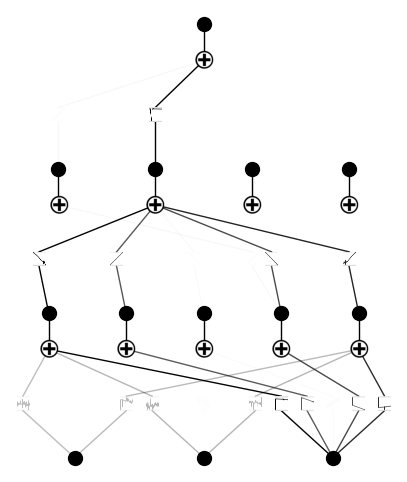

checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


| train_loss: 1.37e-02 | test_loss: 1.97e-02 | reg: 6.51e+00 | : 100%|█| 200/200 [01:38<00:00,  2.02


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 3.71e-02 | test_loss: 5.58e-02 | reg: 3.75e+00 | : 100%|█| 200/200 [01:36<00:00,  2.08


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 3.06e-02 | test_loss: 4.63e-02 | reg: 3.60e+00 | : 100%|█| 200/200 [01:47<00:00,  1.86


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 5.51e-02 | test_loss: 1.01e-01 | reg: 5.64e+00 | : 100%|█| 200/200 [01:48<00:00,  1.84


saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: 1.86e-01 | test_loss: 1.95e-01 | reg: 3.38e+00 | : 100%|█| 200/200 [01:58<00:00,  1.69


saving model version 0.9
saving model version 0.10
Training grid: 100


| train_loss: 2.23e-01 | test_loss: 2.27e-01 | reg: 1.26e+00 | : 100%|█| 200/200 [01:19<00:00,  2.53


saving model version 0.11
saving model version 0.12
Training grid: 200


| train_loss: 1.96e-01 | test_loss: 2.30e-01 | reg: 6.57e+00 | : 100%|█| 200/200 [38:07<00:00, 11.44


saving model version 0.13
Pruning model...
saving model version 0.14


| train_loss: 2.10e-01 | test_loss: 2.30e-01 | reg: 5.68e+00 | : 100%|█| 100/100 [41:31<00:00, 24.92


saving model version 0.15


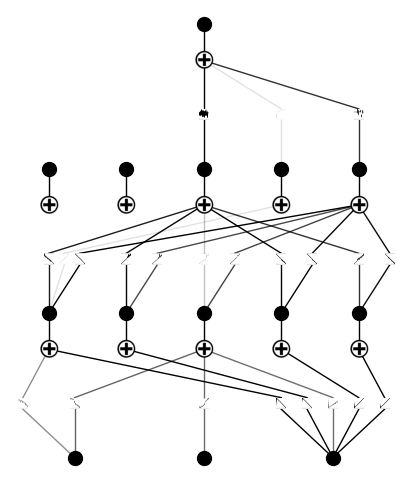

⚠️ WARNING: No model achieved RMSE < 1e-2 for dataset I.16.6
Pruned KAN Smallest Shape: None, 
Pruned KAN lowest loss Shape: [3, 5, 5, 1], 
Pruned KAN lowest loss: 1.9659e-02
--------------------------------
Final Results for dataset I.16.6:
Pruned KAN Smallest Shape: None, 
Pruned KAN lowest loss Shape: [3, 5, 5, 1], 
Pruned KAN lowest loss: 1.9659e-02


In [20]:
results_I_16_6 = full_feynman_experiment(dataset='I.16.6', shape_human=[6, 4, 2, 1, 1], seeds=[0], skip=['unpruned','human','mlp'], depths=[3], plot_model=True, plot_before_prune=True)